**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**July, 2023**

---

# Malaria: Merging genes tables from Differential expression

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import scipy
import matplotlib.pyplot as plt

import seaborn as sns
import scanpy as sc

### Note 
To run this chunk you need:

*rpy2==3.4.2  ///  anndata2ri==1.0.6*

In [2]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri

import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

## Load subset Malaria 24H post-infection 

In [3]:
adata= sc.read('../../../data_integration/results/scVI/malaria_singleCell_24h.h5ad')

#### Subset immune cells

In [4]:
adata =adata[[ i in ['F','PV','F_p','F_sm','Endo_f'] for i in adata.obs.cell_type ]]
adata.write ('../data/malaria_singleCell_24h_FibroEndo.h5ad')

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
del(adata)

# Filtering DEGs

## Reading the DEGs tables per cell type

In [6]:
df1 = pd.read_csv('../results/SC_limma_fibroEndo_MAL_24h/1_DEGs_SC_MAL_24h_F.tsv', index_col=0,sep='\t')
df2 = pd.read_csv('../results/SC_limma_fibroEndo_MAL_24h/2_DEGs_SC_MAL_24h_PV.tsv', index_col=0,sep='\t')
df3 = pd.read_csv('../results/SC_limma_fibroEndo_MAL_24h/3_DEGs_SC_MAL_24h_Endof.tsv', index_col=0,sep='\t')

In [7]:
df1.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
HLA-DQB1,1.740492,4.800328,268.175627,6.820775e-13,4.961432e-09,4.961432e-09
IL1A,1.410089,6.560718,169.960655,1.531624e-12,1.114104e-08,5.570518e-09
SLC43A3,0.685064,5.872149,159.081183,3.119786e-12,2.269333e-08,7.162107e-09
C15orf48,0.995682,7.925145,155.652466,3.938470e-12,2.864843e-08,7.162107e-09
SLC2A1,1.027442,6.796381,151.772000,5.155001e-12,3.749748e-08,7.499496e-09


In [8]:
df2.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
C15orf48,1.387066,6.225848,172.385507,6.192700e-13,5.426044e-09,5.426044e-09
SAMSN1,1.233680,4.497978,119.561670,3.474524e-11,3.044378e-07,9.219040e-08
SNX10,1.564362,3.189589,124.008690,2.347921e-11,2.057248e-07,9.219040e-08
ICAM1,1.099168,7.059811,117.435461,4.208646e-11,3.687616e-07,9.219040e-08
ALOX5AP,1.159447,3.605170,146.496630,6.942756e-11,6.083243e-07,1.216649e-07


In [9]:
df3.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
IL1RN,2.190200,3.914339,184.166411,2.181283e-13,1.816572e-09,1.816572e-09
CCL3L1,2.244097,4.111346,146.678153,2.917805e-12,2.429948e-08,1.214974e-08
IL1A,1.178834,5.366196,123.323318,1.990271e-11,1.657498e-07,5.057966e-08
FTH1,0.839001,12.135905,121.088272,2.429378e-11,2.023186e-07,5.057966e-08
CCL5,2.153293,4.829508,111.313957,6.031100e-11,5.022700e-07,1.004540e-07


#  F

### Defining a thershold for significant Up reg in HBC

In [10]:
df1up= df1[(df1['logFC'] > 0) ]
df1_down= df1[(df1['logFC'] < 0) ]

In [11]:
#df1_down['avg_log2FC']= df1_down['avg_log2FC']*-1

In [12]:
df1_temp = pd.concat([df1up, df1_down])

In [13]:
df1_temp.loc[['IL1B']]

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
IL1B,0.848326,9.589919,25.507255,0.000034,0.248946,0.000481


In [14]:
%%R

library(Cairo)
library(ggplot2)
library(ggrepel)
library(EnhancedVolcano)
library(magrittr)

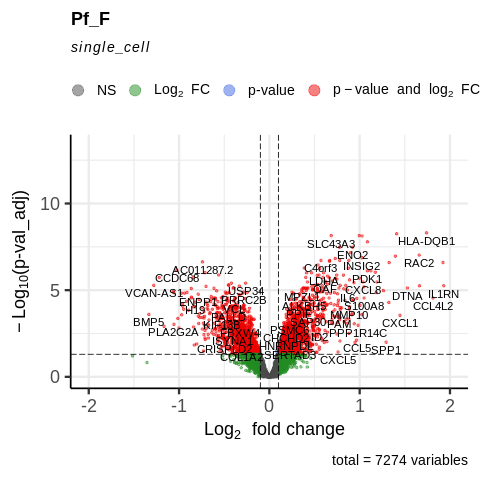

In [15]:
%%R -i df1_temp

EnhancedVolcano(df1_temp, lab = rownames(df1_temp), x="logFC", y="p_val_adj",  
                #selectLab = c('CXCL8','IL1B'),
                
                pCutoff=0.05,
                FCcutoff = 0.1, title = "Pf_F", subtitle = bquote(italic(single_cell)), 
                ylab = bquote(-Log[10] * "(p-val_adj)"), xlim = c(-2, 2), pointSize =1,
                labSize = 4)
#ggsave("volcano_plot_Pf_VCT_fusing_SN_day2.eps",  device=cairo_ps, width =7,   height =7)




In [16]:
x= df1_temp[(df1_temp['p_val_adj'] < 0.05) ]

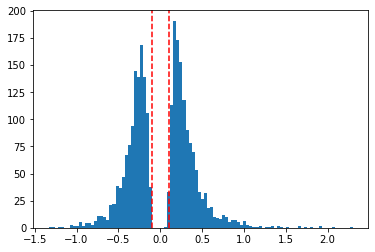

In [17]:
plt.hist(x['logFC'], bins = 100)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(-0.1, linestyle = '--', color = 'red')

## Note:
Save DEGs list:

    p_val_adj < 0.05
    
    avg_log2FC > 0.1
    
    ==> Input to metascape

### Significant Up reg in F

In [21]:
upDEG= df1[ (df1['p_val_adj'] < 0.05) & (df1['logFC'] > 0.1)]

In [22]:
upDEG.to_csv('../results/SC_limma_fibroEndo_MAL_24h/1_DEGs_UP_SC_MAL_24h_F.tsv', index=True, sep='\t')

In [23]:
upDEG.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
HLA-DQB1,1.740492,4.800328,268.175627,6.820775e-13,4.961432e-09,4.961432e-09
IL1A,1.410089,6.560718,169.960655,1.531624e-12,1.114104e-08,5.570518e-09
SLC43A3,0.685064,5.872149,159.081183,3.119786e-12,2.269333e-08,7.162107e-09
C15orf48,0.995682,7.925145,155.652466,3.938470e-12,2.864843e-08,7.162107e-09
SLC2A1,1.027442,6.796381,151.772000,5.155001e-12,3.749748e-08,7.499496e-09


In [24]:
upDEG.shape

(1303, 6)

In [25]:
list(upDEG.index)

['HLA-DQB1',
 'IL1A',
 'SLC43A3',
 'C15orf48',
 'SLC2A1',
 'PFKFB4',
 'ENO2',
 'EGLN3',
 'ICAM1',
 'RAC2',
 'ANKRD37',
 'INSIG2',
 'BNIP3',
 'MTFP1',
 'C4orf3',
 'FAM219A',
 'AK4',
 'PGK1',
 'CCL3L1',
 'TNF',
 'HILPDA',
 'MPC2',
 'TMSB10',
 'ANGPTL4',
 'SMS',
 'PDK1',
 'KCTD11',
 'ADM',
 'LDHA',
 'RNF181',
 'SEC61G',
 'CCL3',
 'FAM13A',
 'TUBA4A',
 'BNIP3L',
 'GPI',
 'GAPDH',
 'AK2',
 'LGALS1',
 'SH3D21',
 'MXI1',
 'FAM162A',
 'SLC2A3',
 'NDRG1',
 'OAF',
 'GPSM3',
 'CXCL8',
 'LPO',
 'SLC25A36',
 'FTH1',
 'RBPJ',
 'C1QA',
 'SLC6A8',
 'ZNF292',
 'GLIPR1',
 'PGAM1',
 'BCKDK',
 'AC108690.1',
 'YEATS2',
 'IL1RN',
 'CCL4',
 'EFHD2',
 'RFX2',
 'DTNA',
 'MARCKS',
 'PKM',
 'FCGR2A',
 'PDXK',
 'SLC39A14',
 'LGALS8',
 'PPP1R18',
 'SCD',
 'COTL1',
 'PSMA6',
 'SLC16A1',
 'BCL2A1',
 'CYBA',
 'MPZL1',
 'HDAC3',
 'SHMT2',
 'MSANTD3',
 'IL6',
 'VIM',
 'HMOX1',
 'RRAGA',
 'WDR45B',
 'WDR54',
 'B3GNT5',
 'ENO1',
 'MT1X',
 'RPL36AL',
 'PDLIM4',
 'LRFN5',
 'UBC',
 'C12orf10',
 'DAD1',
 'NGLY1',
 'NINJ1',
 

In [9]:
#list(upDEG.index)

### Significant Down reg in F

In [26]:
downDEG= df1[(df1['p_val_adj'] < 0.05) & (df1['logFC'] < -0.1)]

In [27]:
downDEG.to_csv('../results/SC_limma_fibroEndo_MAL_24h/1_DEGs_DOWN_SC_MAL_24h_F.tsv', index=True, sep='\t')

In [28]:
downDEG.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
AC011287.2,-0.741158,3.920331,95.343170,6.121423e-10,0.000004,2.343538e-07
CCDC68,-1.025157,5.194794,82.111488,2.614836e-09,0.000019,7.044561e-07
LINC00922,-0.713197,4.457239,77.678766,4.431741e-09,0.000032,9.910945e-07
MFSD14C,-0.560146,4.273438,74.496452,6.567095e-09,0.000048,1.326918e-06
AL117190.2,-0.843039,6.360237,70.457577,1.102431e-08,0.000080,1.831055e-06


In [29]:
downDEG.shape

(1212, 6)

In [31]:
list(downDEG.index)

['AC011287.2',
 'CCDC68',
 'LINC00922',
 'MFSD14C',
 'AL117190.2',
 'EYS',
 'USP34',
 'TTC28',
 'SRGAP2B',
 'VCAN-AS1',
 'FP236383.3',
 'ARHGEF12',
 'AC024560.5',
 'SNHG14',
 'NR2C2',
 'FCMR',
 'RHOBTB1',
 'AC002463.1',
 'AC083870.1',
 'PRRC2B',
 'KIAA0100',
 'HTRA3',
 'WWC1',
 'ARGLU1',
 'IGF1',
 'SLC46A3',
 'NCOA7',
 'ANGPTL2',
 'DDX3X',
 'COL14A1',
 'ENPP1',
 'ATP9B',
 'PTPRA',
 'PRR16',
 'MEG8',
 'ELOVL2',
 'ZCCHC24',
 'DOCK1',
 'C2orf83',
 'SIDT2',
 'PBX1',
 'RUBCN',
 'FAT1',
 'VPS36',
 'NUP98',
 'BTG2',
 'PDE7B',
 'BCAS3',
 'SPIDR',
 'TRIM8',
 'VPS13D',
 'AC010894.3',
 'VCL',
 'CBR4',
 'KCNK3',
 'AC007563.2',
 'C15orf41',
 'AC009271.1',
 'ZNF445',
 'H19',
 'SLC39A10',
 'ZYG11B',
 'THBS1',
 'CSGALNACT1',
 'LINC01091',
 'PTPRK',
 'FMOD',
 'COL4A1',
 'HERC2',
 'SLC26A2',
 'EGFL6',
 'SMC6',
 'LPGAT1',
 'NAPG',
 'GAS7',
 'FSIP1',
 'CPNE8',
 'FAM122C',
 'EPAS1',
 'VSTM4',
 'TSHZ1',
 'NFATC3',
 'PDZD8',
 'TCF12',
 'COL15A1',
 'AL078459.1',
 'PHACTR2',
 'COL4A2',
 'COL5A3',
 'CPLANE1',
 

#  PV

### Significant Up reg in PV

In [32]:
upDEG= df2[(df2['p_val_adj'] < 0.05) & (df2['logFC'] > 0.1)]

In [33]:
upDEG.to_csv('../results/SC_limma_fibroEndo_MAL_24h/2_DEGs_UP_SC_MAL_24h_PV.tsv', index=True, sep='\t')

In [34]:
upDEG.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
C15orf48,1.387066,6.225848,172.385507,6.192700e-13,5.426044e-09,5.426044e-09
SAMSN1,1.233680,4.497978,119.561670,3.474524e-11,3.044378e-07,9.219040e-08
SNX10,1.564362,3.189589,124.008690,2.347921e-11,2.057248e-07,9.219040e-08
ICAM1,1.099168,7.059811,117.435461,4.208646e-11,3.687616e-07,9.219040e-08
ALOX5AP,1.159447,3.605170,146.496630,6.942756e-11,6.083243e-07,1.216649e-07


In [35]:
upDEG.shape

(1148, 6)

In [36]:
list(upDEG.index)

['C15orf48',
 'SAMSN1',
 'SNX10',
 'ICAM1',
 'ALOX5AP',
 'IL1RN',
 'BHLHE40',
 'PFKFB4',
 'ZNF267',
 'S100A8',
 'AC022816.1',
 'NDRG1',
 'CTSS',
 'PRG2',
 'C1QA',
 'SEC61G',
 'SPP1',
 'HMOX1',
 'OSER1',
 'FNIP1',
 'CCNG2',
 'NUP58',
 'PDK1',
 'CCL3',
 'OGT',
 'CADM1',
 'MSANTD3',
 'NFKBIA',
 'ETS1',
 'MTRNR2L1',
 'TNIP1',
 'MAP2K1',
 'ENO2',
 'CDK18',
 'HLA-DQB1',
 'PLEKHF2',
 'RFX2',
 'LRRC49',
 'LUCAT1',
 'PIM3',
 'RSRC2',
 'BNIP3',
 'ADM',
 'ZP3',
 'HMGA1',
 'SQSTM1',
 'RBPJ',
 'SLC2A1',
 'ALCAM',
 'ARRDC3',
 'GBE1',
 'SERPINE1',
 'HK2',
 'SEC24A',
 'HILPDA',
 'REL',
 'CGNL1',
 'RAB8B',
 'GRB10',
 'ROR1',
 'FCER1G',
 'IL7R',
 'PPIF',
 'TFG',
 'IL32',
 'CXCL8',
 'TNF',
 'LMAN1',
 'PPP1R15A',
 'RAP1B',
 'CD83',
 'TNFRSF14',
 'ATF3',
 'FMNL3',
 'ERN1',
 'IRF1',
 'ARL8B',
 'WDR26',
 'RHOG',
 'BTG3',
 'CCL4L2',
 'UTY',
 'SYNJ2',
 'CCL3L1',
 'RIPK2',
 'CREG1',
 'CYLD',
 'FCGR2A',
 'VEGFC',
 'SLC25A37',
 'NRP2',
 'FAM210A',
 'TNFAIP8',
 'INSIG1',
 'MPZL1',
 'AK4',
 'SQLE',
 'TYROBP',
 'ZNF

In [16]:
#list(upDEG.index)

### Significant Down reg in PV

In [37]:
downDEG= df2[ (df2['p_val_adj'] < 0.05) & (df2['logFC'] < -0.1)]

In [38]:
downDEG.to_csv('../results/SC_limma_fibroEndo_MAL_24h/2_DEGs_DOWN_SC_MAL_24h_PV.tsv', index=True, sep='\t')

In [39]:
downDEG.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
SPIDR,-0.453223,6.508110,66.838145,1.237371e-08,0.000108,0.000005
PCDH18,-0.819638,5.633362,66.014389,1.390765e-08,0.000122,0.000005
CYSLTR2,-0.907831,6.249187,57.096647,5.302194e-08,0.000465,0.000012
ECI1,-0.423141,5.181206,54.457459,8.105126e-08,0.000710,0.000014
C17orf58,-0.574097,5.589453,48.815620,2.110968e-07,0.001850,0.000029


In [40]:
downDEG.shape

(971, 6)

In [41]:
list(downDEG.index)

['SPIDR',
 'PCDH18',
 'CYSLTR2',
 'ECI1',
 'C17orf58',
 'CABLES1',
 'LOXL1',
 'HGSNAT',
 'MTUS1',
 'VCAN',
 'LAMA2',
 'MRPS26',
 'FLRT3',
 'RAC3',
 'CZIB',
 'TNFRSF19',
 'CSGALNACT1',
 'NDUFS8',
 'ITGA4',
 'MSX2',
 'TMEM160',
 'PTMS',
 'PEBP1',
 'BTBD3',
 'AL031599.1',
 'SPRY1',
 'TRIOBP',
 'IL1R1-AS1',
 'THAP12',
 'TBCB',
 'SOGA1',
 'FP236383.3',
 'SCP2',
 'TCF21',
 'COL3A1',
 'INKA2',
 'ABCC4',
 'IL1R1',
 'FGD5-AS1',
 'ZNF32',
 'ANO10',
 'HPF1',
 'HSD17B2',
 'KMT2D',
 'ATP13A2',
 'ABRAXAS1',
 'SSNA1',
 'HYAL2',
 'DICER1',
 'TMEM128',
 'SLC39A3',
 'CCDC102B',
 'TMEM14C',
 'IDE',
 'MRPL24',
 'AL365361.1',
 'ANTXR1',
 'WNT3A',
 'ATRAID',
 'P3H4',
 'ZNF428',
 'F2RL1',
 'SAMM50',
 'AC010894.3',
 'PGP',
 'NDUFB10',
 'NSL1',
 'ELOVL2',
 'IFRD2',
 'DDRGK1',
 'IRS1',
 'SAMD1',
 'SAC3D1',
 'TMEM9B',
 'FOXF1',
 'PWWP3A',
 'OBSL1',
 'TMEM141',
 'MXRA8',
 'MICOS13',
 'PHACTR2',
 'SUMF2',
 'PCDH1',
 'ID4',
 'THSD4-AS1',
 'HSPB6',
 'KIF1BP',
 'PRKAR2A',
 'AURKAIP1',
 'PIGX',
 'FAM234A',
 'DIS3L2',


#  Endo_f

### Significant Up reg in Endof

In [42]:
upDEG= df3[ (df3['p_val_adj'] < 0.05) & (df3['logFC'] > 0.1)]

In [43]:
upDEG.to_csv('../results/SC_limma_fibroEndo_MAL_24h/3_DEGs_UP_SC_MAL_24h_Endof.tsv', index=True, sep='\t')

In [44]:
upDEG.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
IL1RN,2.190200,3.914339,184.166411,2.181283e-13,1.816572e-09,1.816572e-09
CCL3L1,2.244097,4.111346,146.678153,2.917805e-12,2.429948e-08,1.214974e-08
IL1A,1.178834,5.366196,123.323318,1.990271e-11,1.657498e-07,5.057966e-08
FTH1,0.839001,12.135905,121.088272,2.429378e-11,2.023186e-07,5.057966e-08
CCL5,2.153293,4.829508,111.313957,6.031100e-11,5.022700e-07,1.004540e-07


In [45]:
upDEG.shape

(1024, 6)

In [46]:
list(upDEG.index)

['IL1RN',
 'CCL3L1',
 'IL1A',
 'FTH1',
 'CCL5',
 'BCL2A1',
 'C15orf48',
 'S100A8',
 'CCL3',
 'SNX10',
 'ARRDC3',
 'OPTN',
 'TNFAIP2',
 'CSF3',
 'IER3',
 'CTSS',
 'RIOK3',
 'HK2',
 'DAPK3',
 'CXCL3',
 'KYNU',
 'SOD2',
 'ANGPTL4',
 'AL078604.4',
 'NDRG1',
 'TNS1',
 'C1QA',
 'CCNG2',
 'CSTB',
 'IRF1',
 'MCTP1',
 'TNFAIP3',
 'FTL',
 'WDR45B',
 'NFKBIA',
 'CCL4',
 'PRG2',
 'POU2F2',
 'BRI3',
 'IFNGR2',
 'TNIP1',
 'MTRNR2L1',
 'RNF144B',
 'GABARAP',
 'CR1L',
 'HNMT',
 'CDKN1B',
 'NUAK2',
 'UBE2B',
 'MYOF',
 'CREBRF',
 'ADORA2A',
 'CRIM1-DT',
 'RHOG',
 'BNIP3',
 'ICAM1',
 'EFNA1',
 'SAMSN1',
 'MTFP1',
 'CLK1',
 'ANKRD37',
 'CXCL1',
 'COTL1',
 'B2M',
 'TNF',
 'GAPDH',
 'S100A10',
 'NEU1',
 'RBM3',
 'HILPDA',
 'RSRC2',
 'SQSTM1',
 'SEC61G',
 'SDCBP',
 'P4HA1',
 'TMED10',
 'SEC24A',
 'ANXA5',
 'UPP1',
 'GDF15',
 'STC2',
 'TRAF1',
 'FAM200B',
 'PPP1R18',
 'ENO2',
 'IL1B',
 'LDHA',
 'KLHL24',
 'S100A9',
 'CCL4L2',
 'GLRX',
 'ATP6V1C1',
 'PRKCA',
 'CXCL8',
 'LINC02246',
 'TNFRSF10B',
 'CLEC2B',
 'B

In [23]:
#list(upDEG.index)

### Significant Down reg in Endof

In [47]:
downDEG= df3[(df3['p_val_adj'] < 0.05) & (df3['logFC'] < -0.1)]

In [48]:
downDEG.to_csv('../results/SC_limma_fibroEndo_MAL_24h/3_DEGs_DOWN_SC_MAL_24h_Endof.tsv', index=True, sep='\t')

In [49]:
downDEG.head()

,logFC,logCPM,F,PValue,bonferroni,p_val_adj
PURA,-0.444447,5.440888,92.799627,4.100886e-10,0.000003,2.846015e-07
FAM89A,-0.560929,7.550719,74.004375,4.021444e-09,0.000033,1.339623e-06
THSD1,-0.359454,5.604468,51.820779,1.128646e-07,0.000940,1.999865e-05
FP325318.1,-0.397504,5.166200,51.201283,1.255496e-07,0.001046,2.113495e-05
AC011453.1,-0.723313,5.867124,50.463596,1.426905e-07,0.001188,2.242125e-05


In [50]:
downDEG.shape

(722, 6)

In [51]:
list(downDEG.index)

['PURA',
 'FAM89A',
 'THSD1',
 'FP325318.1',
 'AC011453.1',
 'VASH1',
 'GFOD1',
 'MT-ND6',
 'PCDH17',
 'AGFG2',
 'DIS3L2',
 'FUT9',
 'ABCA1',
 'GNG11',
 'EDNRB',
 'H19',
 'AC073167.1',
 'KRBA2',
 'AC097528.1',
 'TFPI2',
 'MEG9',
 'COBLL1',
 'HACD3',
 'CKAP5',
 'BCL2L14',
 'AC092142.1',
 'SETBP1',
 'ITFG1',
 'HGSNAT',
 'MCPH1',
 'TUBE1',
 'AC010894.3',
 'TRAPPC9',
 'TBC1D4',
 'INSYN2A',
 'LXN',
 'RESF1',
 'GRIK2',
 'EHMT1',
 'NSD1',
 'ENOX2',
 'FAM229B',
 'TCF4-AS1',
 'MAEL',
 'MEIS2',
 'LINC01194',
 'MRTFB',
 'PON2',
 'AP001442.1',
 'SNHG14',
 'DIAPH2-AS1',
 'ACACA',
 'PPM1L',
 'RSRC1',
 'MEOX2',
 'MEF2C-AS2',
 'DACH1',
 'SPATA5',
 'SLF2',
 'KIAA1217',
 'EFCAB14',
 'RBMS3-AS2',
 'LPCAT2',
 'AL365295.1',
 'GATA2-AS1',
 'AC131025.3',
 'ABCA3',
 'AC079772.1',
 'AC093515.1',
 'IMMP2L',
 'HOXA13',
 'VPS13B',
 'PHF14',
 'METTL8',
 'RASGRF2',
 'GTF2I',
 'LDB2',
 'AC027097.2',
 'TTC28',
 'ARL17A',
 'RNGTT',
 'HLX',
 'DLG2',
 'BBOX1-AS1',
 'ALG9',
 'FP236383.3',
 'AP003086.1',
 'AL157871.4',
 '